# Machine Learning Models

## 1. Load Dataset

Cleaned Dataset (from [Statistical Analysis](../StatisticalAnalysis/StatisticalAnalysis.py)) is loaded and splitted into training and testing dataset with a 0.25 `test_size` using the `train_test_split` function of [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with stratify by `Quality of Sleep`. Due to insufficient training instances and class imbalance is necessary to perform a stratified split that benefits the training dataset (meaning, a smaller test dataset).

In [1]:
# Importing libraries and functionalities
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split


# Importing functions and utils
import SourceMachineLearning as src

In [2]:
# Loading dataset

SleepDataset = pd.read_csv(
    src.PATH+'CleanSleepDataset.csv',
    index_col = 0,
)

In [3]:
# Splitting columns into features (numerical, binary, categorical) and target

Target = 'Quality of Sleep'
Features = [feature for feature in SleepDataset.columns if feature != Target]

NumericalFeatures , BinaryFeatures, CategoricalFeatures = src.SplittingFeatures(SleepDataset,Features)

In [4]:
# Splitting dataset into train and test

SleepDataset_Train , SleepDataset_Test = train_test_split(
    SleepDataset,
    test_size = 0.25,
    stratify = SleepDataset[Target],
    random_state = src.RANDOM_STATE,
)

## 2. Preprocessing Pipeline

For the dataset preprocessing, each of the categorical features are encoded and the numerical features are standardized. The encoding will allow the model to learn from categorical features, while standardization reduces noise by different scales. No feature engineering was applied during preprocessing neither feature selection (although some features have a high linear correlation with each other).

In [5]:
# Importing functionalities

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler , OrdinalEncoder , OneHotEncoder 

In [6]:
# Pipelines for preprocessing by type of feature

NumericalPreprocessing = Pipeline(
    [
        ('Standardization',StandardScaler()),
    ]
)

BinaryPreprocessing = Pipeline(
    [
        ('Encoder',OrdinalEncoder()),
    ]
)

CategoricalPreprocessing = Pipeline(
    [
        ('Encoder',OneHotEncoder()),
    ]
)

# Pipeline for preprocessing

PreprocessingPipeline = ColumnTransformer(
    [
        ('Numerical Preprocessing',NumericalPreprocessing,NumericalFeatures),
        ('Binary Preprocessing',BinaryPreprocessing,BinaryFeatures),
        ('Categorical Preprocessing',CategoricalPreprocessing,CategoricalFeatures),
    ]
)

PreprocessingPipeline

,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


## 3. Models

`Quality of Sleep` is a discrete feature (each value represents a class) which implies that the models should be classifiers to model properly the quality of sleep of a patient. The models that were chosen represent a reduced collection of techniques and ways of approaching the classification problem, where the priority was to have a greater diversification of them. Specifically, the following were chosen:
* Logistic Regression
* Random Forest
* SVM
* AdaBoost

With the definition of the models and hyperparameters to be optimized (the more suitable and flexible to optimize), the model fine-tunning is performed using [Optuna](https://optuna.org/) as framework to search for the best hyperparameters of each model. For determining the best hyperparameters, F1 score with weighted average is used because the dataset is imbalanced with respect to the target (`Quality of Sleep`) and this metric will reduce the generation of trivial models that excel at predicting the majority classes. Finally, the models with the best hyperparameters are saved (dumped).

### 3.1. Logistic Regression

In [7]:
# Defining Logistic Regression model

from sklearn.linear_model import LogisticRegression

LogisticRegressionPipeline = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Model',LogisticRegression(
            penalty='elasticnet',solver='saga',
            random_state=src.RANDOM_STATE,n_jobs=-1
        )),
    ]
)

LogisticRegressionParameters = {
    'Model__C':('float',[1e-10,2]),
    'Model__l1_ratio':('float',[0,1]),
}


LogisticRegressionPipeline

,steps,"[('Preprocessing', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 3.2. Random Forest

In [8]:
# Defining Random Forest model

from sklearn.ensemble import RandomForestClassifier

RandomForestPipeline = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Model',RandomForestClassifier(
            random_state=src.RANDOM_STATE,n_jobs=-1,
        )),
    ]
)

RandomForestParameters = {
    'Model__n_estimators': ('int',[1,50]),
    'Model__max_depth': ('int',[1,6]),
    'Model__criterion': ('categorical',['gini','entropy'])
}


RandomForestPipeline

,steps,"[('Preprocessing', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 3.3. Support Vector Machine (SVM)

In [9]:
# Defining Support Vector Machine model

from sklearn.svm import SVC

SVMPipeline = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Model',SVC(
            random_state=src.RANDOM_STATE,
        )),
    ]
)

SVMParameters = {
    'Model__C':('float',[1e-10,2]),
    'Model__kernel':('categorical',['poly','rbf','sigmoid']),
    'Model__degree':('int',[1,5]),
    'Model__gamma':('float',[1e-10,2]),
    'Model__coef0':('float',[0,2]),
}


SVMPipeline

,steps,"[('Preprocessing', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 3.4. Adaptive Boosting (AdaBoost)

In [10]:
# Defining Random Forest model

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

AdaBoostPipeline = Pipeline(
    [
        ('Preprocessing',PreprocessingPipeline),
        ('Model',AdaBoostClassifier(
            random_state=src.RANDOM_STATE,
        )),
    ]
)

base_estimators = [DecisionTreeClassifier(max_depth=depth,random_state=src.RANDOM_STATE) for depth in range(1,3)]
AdaBoostParameters = {
    'Model__estimator':('categorical',base_estimators),
    'Model__n_estimators':('int',[1,50]),
    'Model__learning_rate':('float',[1e-12,2]),
}


AdaBoostPipeline

,steps,"[('Preprocessing', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical Preprocessing', ...), ('Binary Preprocessing', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 3.5. Training and Fine-Tunning Models

In [11]:
# Defining containers for models and their params to optimize, 
# and variables for saving best models

ModelNames = [
    'Logistic Regression',
    'Random Forest',
    'SVM',
    'AdaBoost',
]

ModelsParams = [
    (LogisticRegressionPipeline,LogisticRegressionParameters),
    (RandomForestPipeline,RandomForestParameters),
    (SVMPipeline,SVMParameters),
    (AdaBoostPipeline,AdaBoostParameters)
]

In [12]:
# Importing auxiliars para ignore warnings

import warnings
from sklearn.exceptions import ConvergenceWarning

# Fine-tunning and training of models

from copy import deepcopy

BestModels = []
_NumTrials = 10
_Metric = src.F1_ML
with warnings.catch_warnings():
    warnings.simplefilter('ignore',category=ConvergenceWarning)
    warnings.simplefilter('ignore',category=UserWarning)

    TrainDataset_X = SleepDataset_Train[Features]
    TrainDataset_y = SleepDataset_Train[Target]
    TestDataset_X = SleepDataset_Test[Features]
    TestDataset_y = SleepDataset_Test[Target]

    for (_model , _params) , _model_name in zip(ModelsParams,ModelNames):
        # Defining optimizer
        _trainer = src.MachineLearningTrainer(
            _model,
            _params,
            _Metric,
        )

        # Fine-tuning of hyperparameters
        print(f' Start Fine-Tuning of {_model_name} '.center(50,'='))
        _best_params = _trainer(
            TrainDataset_X,
            TrainDataset_y,
            TestDataset_X,
            TestDataset_y,
            NumTrials = _NumTrials,
            NumJobs = 1,
        )

        # Training model with the best parameters
        _best_model = deepcopy(_model)
        _best_model.set_params(**_best_params)
        _best_model.fit(TrainDataset_X,TrainDataset_y)
        BestModels.append(deepcopy(_best_model))

    print('\n',' Start Models Evaluation '.center(50,'='))
    for _best_model , _model_name in zip(BestModels,ModelNames):
        _score = _Metric(_best_model,TestDataset_X,TestDataset_y)
        print(f'Best {_model_name} Model obtains :: {_score} Score')

[I 2025-11-12 15:14:42,618] A new study created in memory with name: OptimizeModel
[I 2025-11-12 15:14:42,711] Trial 0 finished with value: 0.9311622001924534 and parameters: {'Model__C': 1.805749654325545, 'Model__l1_ratio': 0.039334898194143375}. Best is trial 0 with value: 0.9311622001924534.
[I 2025-11-12 15:14:42,785] Trial 1 finished with value: 0.9347082994832335 and parameters: {'Model__C': 0.9773533730350942, 'Model__l1_ratio': 0.3872766509313269}. Best is trial 1 with value: 0.9347082994832335.


==== Start Fine-Tuning of Logistic Regression ====


[I 2025-11-12 15:14:42,871] Trial 2 finished with value: 0.9246377834448449 and parameters: {'Model__C': 1.0716201775281124, 'Model__l1_ratio': 0.7067234788648733}. Best is trial 1 with value: 0.9347082994832335.
[I 2025-11-12 15:14:42,947] Trial 3 finished with value: 0.9347082994832335 and parameters: {'Model__C': 1.2239410939789823, 'Model__l1_ratio': 0.43916599714264837}. Best is trial 1 with value: 0.9347082994832335.
[I 2025-11-12 15:14:43,036] Trial 4 finished with value: 0.9347082994832335 and parameters: {'Model__C': 1.9052913283388226, 'Model__l1_ratio': 0.45422198922500967}. Best is trial 1 with value: 0.9347082994832335.
[I 2025-11-12 15:14:43,123] Trial 5 finished with value: 0.9311622001924534 and parameters: {'Model__C': 1.7240221423208606, 'Model__l1_ratio': 0.06201829790881541}. Best is trial 1 with value: 0.9347082994832335.
[I 2025-11-12 15:14:43,219] Trial 6 finished with value: 0.9246377834448449 and parameters: {'Model__C': 0.6337775677332995, 'Model__l1_ratio': 0

======= Start Fine-Tuning of Random Forest =======


[I 2025-11-12 15:14:43,780] Trial 1 finished with value: 0.8681844320142194 and parameters: {'Model__n_estimators': 7, 'Model__max_depth': 3, 'Model__criterion': 'gini'}. Best is trial 1 with value: 0.8681844320142194.
[I 2025-11-12 15:14:43,848] Trial 2 finished with value: 0.9209678422444378 and parameters: {'Model__n_estimators': 5, 'Model__max_depth': 5, 'Model__criterion': 'gini'}. Best is trial 2 with value: 0.9209678422444378.
[I 2025-11-12 15:14:43,923] Trial 3 finished with value: 0.8681844320142194 and parameters: {'Model__n_estimators': 6, 'Model__max_depth': 3, 'Model__criterion': 'gini'}. Best is trial 2 with value: 0.9209678422444378.
[I 2025-11-12 15:14:44,002] Trial 4 finished with value: 0.9804318334981663 and parameters: {'Model__n_estimators': 15, 'Model__max_depth': 6, 'Model__criterion': 'entropy'}. Best is trial 4 with value: 0.9804318334981663.
[I 2025-11-12 15:14:44,088] Trial 5 finished with value: 0.7469543423776833 and parameters: {'Model__n_estimators': 6, '

============ Start Fine-Tuning of SVM ============


[I 2025-11-12 15:14:44,948] Trial 8 finished with value: 0.9787554956516157 and parameters: {'Model__C': 1.9052760286652581, 'Model__kernel': 'poly', 'Model__degree': 1, 'Model__gamma': 1.7023678963295612, 'Model__coef0': 1.961906275997301}. Best is trial 6 with value: 0.9877250409165302.
[I 2025-11-12 15:14:44,971] Trial 9 finished with value: 0.9787554956516157 and parameters: {'Model__C': 1.8203488972152122, 'Model__kernel': 'poly', 'Model__degree': 1, 'Model__gamma': 0.7823279964214548, 'Model__coef0': 0.09666830096914758}. Best is trial 6 with value: 0.9877250409165302.
[I 2025-11-12 15:14:44,986] A new study created in memory with name: OptimizeModel
[I 2025-11-12 15:14:45,058] Trial 0 finished with value: 0.7113690092413496 and parameters: {'Model__estimator': DecisionTreeClassifier(max_depth=1, random_state=8013), 'Model__n_estimators': 28, 'Model__learning_rate': 0.08401440866646435}. Best is trial 0 with value: 0.7113690092413496.
[I 2025-11-12 15:14:45,126] Trial 1 finished 

========= Start Fine-Tuning of AdaBoost ==========


[I 2025-11-12 15:14:45,193] Trial 2 finished with value: 0.2723404255319149 and parameters: {'Model__estimator': DecisionTreeClassifier(max_depth=1, random_state=8013), 'Model__n_estimators': 22, 'Model__learning_rate': 0.9203030992323098}. Best is trial 1 with value: 0.7655425672076921.
[I 2025-11-12 15:14:45,281] Trial 3 finished with value: 0.9894013787630808 and parameters: {'Model__estimator': DecisionTreeClassifier(max_depth=2, random_state=8013), 'Model__n_estimators': 35, 'Model__learning_rate': 1.8155878209267695}. Best is trial 3 with value: 0.9894013787630808.
[I 2025-11-12 15:14:45,342] Trial 4 finished with value: 0.5327926842050099 and parameters: {'Model__estimator': DecisionTreeClassifier(max_depth=1, random_state=8013), 'Model__n_estimators': 23, 'Model__learning_rate': 0.49615014522351425}. Best is trial 3 with value: 0.9894013787630808.
[I 2025-11-12 15:14:45,436] Trial 5 finished with value: 0.03204199395002415 and parameters: {'Model__estimator': DecisionTreeClassi


 ============ Start Models Evaluation =============
Best Logistic Regression Model obtains :: 0.9347082994832335 Score
Best Random Forest Model obtains :: 0.9910304547350856 Score
Best SVM Model obtains :: 0.9877250409165302 Score
Best AdaBoost Model obtains :: 0.9894013787630808 Score


In [13]:
# Saving best models

for _best_model , _model_name in zip(BestModels,ModelNames):
    print('\n',f' Start Save {_model_name} Model '.center(50,'='))
    # src.SaveModel(_best_model,'./SaveModels/',_model_name)


 ====== Start Save Logistic Regression Model ======

 ========= Start Save Random Forest Model =========

 ============== Start Save SVM Model ==============

 =========== Start Save AdaBoost Model ============


## 4. Result Analysis and Model Comparison

Given that the target variable (`Quality of Sleep`) is ordinal, a correctly generalized and well-trained model is expected to misclassify by predicting a class either one level above or one level below the true class. (This behavior is further accentuated by the existing class imbalance in the dataset). Therefore, the chosen model must not only have good metrics but also exhibit this specific behavior.

The confusion matrices generated by each model allow us to observe their respective classification behavior. It is worth noting that the AdaBoost-based model has a high F1 score ($99.0321\%$), and its misclassifications are consistently one class level away from the true class. This allows its predictions to be more reliable, even though it only misclassified a single instance, similar to the Random Forest-based model.

From the plots generated during "Statistical Analysis," it could be appreciated that the different target classes were not linearly separable. This resulted in the Logistic Regression-based model not achieving the best results (scores) compared to the other models, serving more as a baseline. Considering the interaction between features (either through polynomial or non-linear operations) allows for better capture of the aspects that characterize and distinguish the different classes, enabling the Support Vector Machine (SVM)-based model to achieve superior results.

Ensemble-based models exhibit the best performance and scores due to their training methodology. By being constituted of simple models trained on subsets of the training dataset, each component model is allowed to focus on predicting certain classes. This mechanism leads to better generalization and more robust predictions. This makes them the most suitable for this classification problem, given that the classes are not easily separable.

Based on the preceding discussion, the AdaBoost-based model is the most appropriate for deployment in a production environment, primarily because its performance verifies the expected behavior for a model addressing this specific problem.

In [14]:
# Saving best models

BestModels = []
for _model_name in ModelNames:
    print('\n',f' Start Load {_model_name} Model '.center(50,'='))
    _model = src.LoadModel('./SaveModels/',_model_name)
    BestModels.append(_model)


 ====== Start Load Logistic Regression Model ======

 ========= Start Load Random Forest Model =========

 ============== Start Load SVM Model ==============

 =========== Start Load AdaBoost Model ============


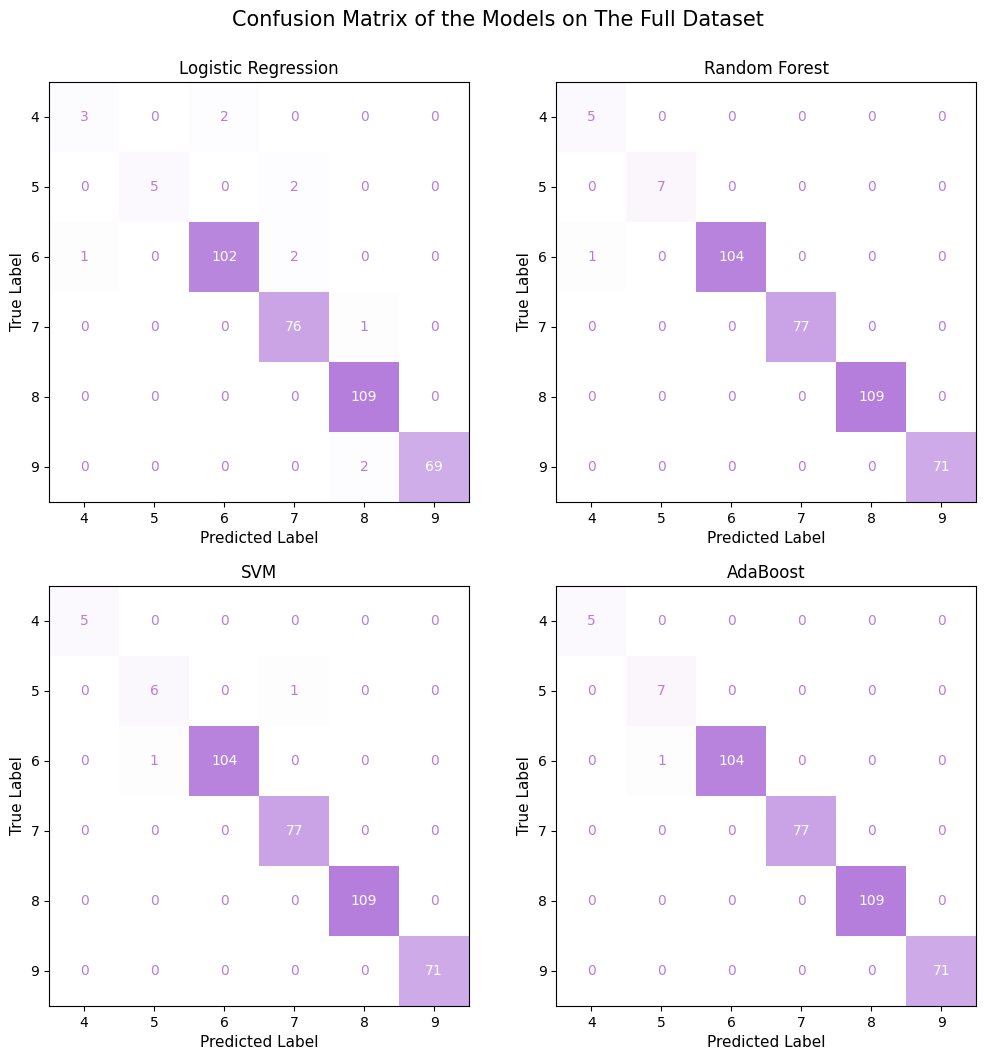

In [15]:
# Plotting of confusion matrix by model

from sklearn.metrics import ConfusionMatrixDisplay

fig , axes = plt.subplots(2,2,figsize=(12,12))

for _best_model , _model_name , _ax in zip(BestModels,ModelNames,axes.ravel()):
    ConfusionMatrixDisplay.from_estimator(
        _best_model,
        SleepDataset[Features],
        SleepDataset[Target],
        cmap = src.ColorMapBinary,
        colorbar = False, 
        ax = _ax,
    )
    _ax.set_title(_model_name)
    _ax.set_xlabel('Predicted Label',size=11)
    _ax.set_ylabel('True Label',size=11)

# fig.savefig('../Resources/ConfusionMatrix_Modeles.jpg')
fig.suptitle('Confusion Matrix of the Models on The Full Dataset',y=0.94,size=15);

In [16]:
# Evaluating models

from sklearn.metrics import accuracy_score , precision_recall_fscore_support

EvaluationScoreResults = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'],dtype=float)
EvaluationScoreResults.rename_axis(index='Model',inplace=True)

for _best_model , _model_name in zip(BestModels,ModelNames):
    _pred_y = _best_model.predict(TestDataset_X)
    accuracy = accuracy_score(TestDataset_y,_pred_y)
    *metrics , _ = precision_recall_fscore_support(TestDataset_y,_pred_y,average='weighted')
    EvaluationScoreResults.loc[_model_name] = [accuracy,*metrics]

EvaluationScoreResults.sort_values('F1',inplace=True)
EvaluationScoreResults

,Accuracy,Precision,Recall,F1
Model,,,,
Logistic Regression,0.936170,0.938227,0.936170,0.934708
SVM,0.978723,0.979255,0.978723,0.978755
AdaBoost,0.989362,0.992908,0.989362,0.990321
Random Forest,0.989362,0.994681,0.989362,0.991030


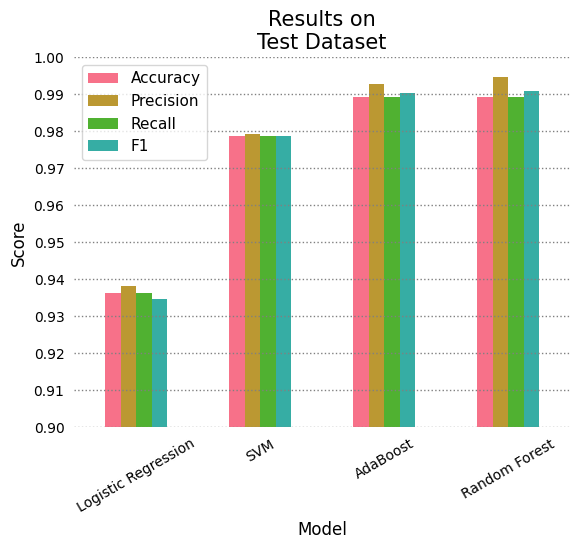

In [17]:
# Plotting models scores

fig = src.PlotResults(EvaluationScoreResults,'Test')
# fig.savefig('../Resources/Results_Models.jpg')